# CS 7641 unsupervised learning
## Datasets preprocessing
### Install packages and dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Dataset retrieval

In [2]:
# If in google colab, it will retrieve datasets from colab instead of local environment
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Load the dataset
if(IN_COLAB): #Grab from google drive
  from google.colab import drive
  drive.mount('/content/drive')
  crabData = pd.read_csv('/content/drive/MyDrive/gatech/CrabAgePrediction.csv')
  sportsCarData = pd.read_csv('/content/drive/MyDrive/gatech/SportsCarPrice.csv')
else: #Grab from local environment
  crabData = pd.read_csv('CrabAgePrediction.csv')
  sportsCarData = pd.read_csv('SportsCarPrice.csv')

Mounted at /content/drive


### Exploratory Data Analysis and Data Preprocessing

#### Crab Data

In [3]:
# Crab data pre-processing
# Remove indeterminate sex rows
crabData = crabData[crabData['Sex'] != 'I']

# One hot encode sex, with M as 1
crabData ['Sex'] = (crabData['Sex'] == "M").astype(int)

<ipython-input-3-6d4241e8b72b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crabData ['Sex'] = (crabData['Sex'] == "M").astype(int)


In [4]:
# Data normalization
# Weight is a magnitude of 10x larger than length and 100x larger than height

scaler = StandardScaler()
numeric_cols = crabData.select_dtypes(include=['float64', 'int']).columns.tolist()
numeric_cols.remove('Sex')
crabData[numeric_cols] = scaler.fit_transform(crabData[numeric_cols])

In [5]:
# Drop highly correlated features
# The crab data has a bunch of weight features that are highly correlated. I have little domain knowledge that would suggest keep shell and viscera weights are helpful.

crabData.drop(['Shucked Weight', 'Viscera Weight', 'Shell Weight'], axis=1, inplace=True)


In [6]:
# Save data with label for NN later
crabDataWithLabel = crabData
crabData.head(5)

,Sex,Length,Diameter,Height,Weight,Age
0,0,0.056665,0.298727,0.280664,-0.326218,-0.626186
1,1,-2.242133,-2.368404,-1.846683,-1.826744,-1.607137
3,0,-1.040489,-1.161845,-1.447806,-1.196456,-0.299202
5,0,0.526873,0.235224,-0.384132,-0.012180,-0.953170
6,0,-0.518035,-0.590317,-0.650050,-0.866938,1.335716


From the EDA in the supervised learning assignment, we know there is no missing data nor that many outliers. The data is top notch clean.

#### Sports Car Data

In [7]:
sportsCarData.head(5)

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,Porsche,911,2022,3,379,331,4,"101,200"
1,Lamborghini,Huracan,2021,5.2,630,443,2.8,"274,390"
2,Ferrari,488 GTB,2022,3.9,661,561,3,"333,750"
3,Audi,R8,2022,5.2,562,406,3.2,"142,700"
4,McLaren,720S,2021,4,710,568,2.7,"298,000"


The sports car data is actually perfect for clustering on price. Domain knowledge tells us that car manufacturers actually create different categories and price levels of cars in order to reach every level of consumer. Lets see if we can identify these levels with clustering.

In [8]:
# Preprocessing
# Remove identification labels
sportsCarData = sportsCarData.iloc[:, 2:]

I'm not particularly interested in deal with small numbers of cars from 2020 and older. Lets simply remove those and one-hot encode 2022 as one and 2021 as zero.

In [9]:
# Remove rows with year not 2022 or 2021
sportsCarData = sportsCarData[sportsCarData['Year'].isin([2021,2022])]

# One hot encode year column, 2022 --> 1, 2021 --> 0
sportsCarData ['Year'] = (sportsCarData['Year'] == 2022).astype(int)
sportsCarData.shape

(958, 6)

In [10]:
# Remove Hybrid and Electric engines from engine size. Lets stick with gas engined cars for this analysis.
unwantedStrings = ['Electric', 'Electric Motor', 'Hybrid', '4.0 (Hybrid)', '2.0 (Electric)', 'Hybrid (4.0)', 'Electric (4.0)', 'Electric (100 kWh)', 'Electric (93 kWh)', 'Electric (tri-motor)', '-']
sportsCarData = sportsCarData[~sportsCarData['Engine Size (L)'].isin(unwantedStrings)]

# Make engine size column numeric
sportsCarData['Engine Size (L)'] = pd.to_numeric(sportsCarData['Engine Size (L)'])

#Drop rows with NaN
sportsCarData = sportsCarData.dropna()

In [11]:
rows_with_nan = sportsCarData[sportsCarData.isna().any(axis=1)]
print(rows_with_nan)

Empty DataFrame
Columns: [Year, Engine Size (L), Horsepower, Torque (lb-ft), 0-60 MPH Time (seconds), Price (in USD)]
Index: []


In [12]:
sportsCarData.dtypes

Year                         int64
Engine Size (L)            float64
Horsepower                  object
Torque (lb-ft)              object
0-60 MPH Time (seconds)     object
Price (in USD)              object
dtype: object

In [13]:
# Make price numeric
sportsCarData['Price (in USD)'] = sportsCarData['Price (in USD)'].str.replace(',', '') # Remove commas from price column
sportsCarData = sportsCarData.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.name != 'Year' else col)

In [14]:
# Z-scale normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = sportsCarData.select_dtypes(include=['float64', 'int']).columns.tolist()
numeric_cols.remove('Year')
sportsCarData[numeric_cols] = scaler.fit_transform(sportsCarData[numeric_cols])

In [15]:
crabData.head(5)

,Sex,Length,Diameter,Height,Weight,Age
0,0,0.056665,0.298727,0.280664,-0.326218,-0.626186
1,1,-2.242133,-2.368404,-1.846683,-1.826744,-1.607137
3,0,-1.040489,-1.161845,-1.447806,-1.196456,-0.299202
5,0,0.526873,0.235224,-0.384132,-0.012180,-0.953170
6,0,-0.518035,-0.590317,-0.650050,-0.866938,1.335716


In [16]:
sportsCarData.head(5)

,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,1,-1.003780,-0.938759,-1.030121,0.577507,-0.345381
1,0,0.602884,0.150453,-0.402681,-1.081369,-0.094937
2,1,-0.346508,0.284978,0.258372,-0.804889,-0.009099
3,1,0.602884,-0.144632,-0.609960,-0.528410,-0.285369
4,0,-0.273478,0.497613,0.297587,-1.219608,-0.060796


## Expectation Maximization

In [17]:
# Remove sex column from data for clustering
crabSexColumn = crabData.iloc[:, 0:1]
crabData = crabData.iloc[:, 1:]

In [18]:
sportsCarData

# Remove year column for sports car data
sportsCarYearColumn = sportsCarData.iloc[:, 0:1]
sportsCarData = sportsCarData.iloc[:, 1:]

In [19]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import timeit

def evaluate_gmm(data, n_components):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data)
    labels = gmm.predict(data)
    if n_components > 1:  # Silhouette score is not defined for a single cluster
        silhouette_avg = silhouette_score(data, labels)
    else:
        silhouette_avg = None
    return silhouette_avg

def find_best_gmm(data, min_clusters=1, max_clusters=10):
    results = []

    for n_components in range(min_clusters, max_clusters + 1):
        # Use a lambda function to capture the current data and n_components
        time_taken = timeit.timeit(lambda: evaluate_gmm(data, n_components), number=1)

        # Get silhouette score
        silhouette_avg = evaluate_gmm(data, n_components)

        # Store results
        results.append({
            'n_clusters': n_components,
            'time': time_taken,
            'silhouette_score': silhouette_avg
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def graph_results(results_df, title):
    # Setting up the subplots
    fig, ax1 = plt.subplots()

    # Plotting silhouette scores
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Silhouette Score', color=color)
    ax1.plot(results_df['n_clusters'], results_df['silhouette_score'], marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiating a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Plotting computation time
    color = 'tab:red'
    ax2.set_ylabel('Computation Time (s)', color=color)
    ax2.plot(results_df['n_clusters'], results_df['time'], marker='x', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Title of the graph
    plt.title(title)

    # Show the legend
    ax1.legend(['Silhouette Score'], loc='upper left')
    ax2.legend(['Computation Time'], loc='upper right')

    fig.tight_layout()  # To ensure the right y-label is not slightly clipped
    plt.show()  # To display the plot


### Crab Data Expectation Maximization

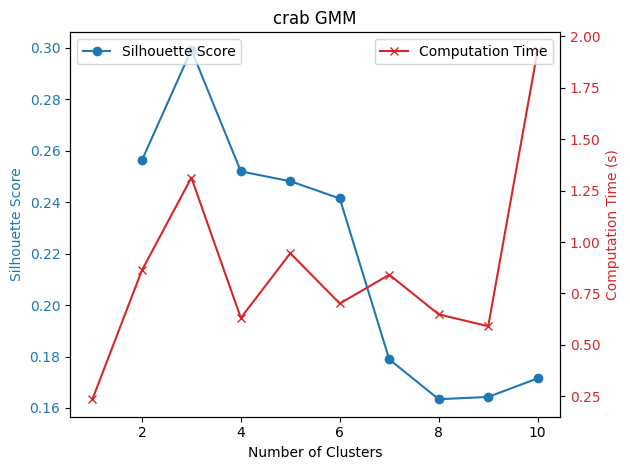

In [20]:
crab_EM_results_df = find_best_gmm(crabData, min_clusters=1, max_clusters=10)
graph_results(crab_EM_results_df, 'crab GMM')

### Sports Car Data Expectation Maximization

In [21]:
sportsCarData = sportsCarData.where(pd.notnull(sportsCarData), None)

# Display all rows that have at least one NaN value
rows_with_nan = sportsCarData[sportsCarData.isna().any(axis=1)]
print(rows_with_nan)

     Engine Size (L)  Horsepower  Torque (lb-ft)  0-60 MPH Time (seconds)  \
885        -3.194684         NaN             NaN                -2.325526   
898         2.647728         NaN             NaN                -1.634327   

     Price (in USD)  
885       -0.202510  
898        3.846463  


In [22]:
sportsCarData = sportsCarData.dropna()

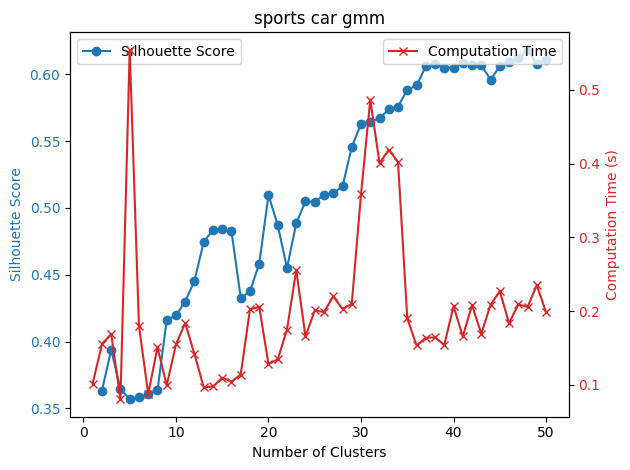

In [23]:
sports_car_EM_results_df = find_best_gmm(sportsCarData, min_clusters=1, max_clusters=50)
graph_results(sports_car_EM_results_df, 'sports car gmm')

## kmeans

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import timeit

def evaluate_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(data)
    if n_clusters > 1:  # Silhouette score is not defined for a single cluster
        silhouette_avg = silhouette_score(data, labels)
    else:
        silhouette_avg = None
    return silhouette_avg

def find_best_kmeans(data, min_clusters=1, max_clusters=10):
    results = []

    for n_clusters in range(min_clusters, max_clusters + 1):
        # Use timeit to measure the execution time
        start_time = timeit.default_timer()
        silhouette_avg = evaluate_kmeans(data, n_clusters)
        time_taken = timeit.default_timer() - start_time

        # Store results
        results.append({
            'n_clusters': n_clusters,
            'time': time_taken,
            'silhouette_score': silhouette_avg
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

### Crab Data kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

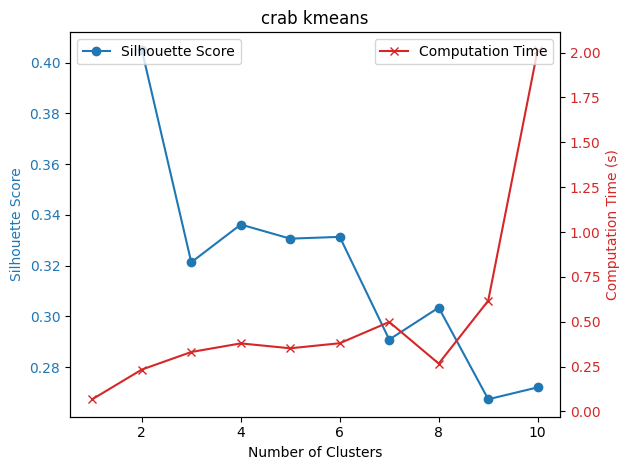

In [25]:
crab_kmeans_results_df = find_best_kmeans(crabData, min_clusters=1, max_clusters=10)
graph_results(crab_kmeans_results_df, 'crab kmeans')

### Sports Car Data kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

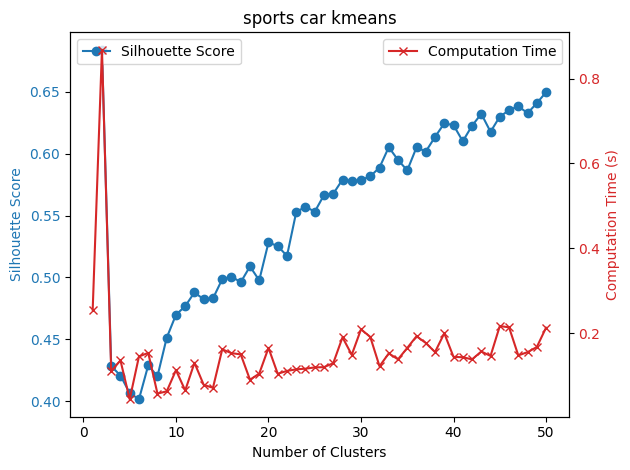

In [26]:
sports_car_data_results_df = find_best_kmeans(sportsCarData, min_clusters=1, max_clusters=50)
graph_results(sports_car_data_results_df, 'sports car kmeans')

## Principle component analysis (PCA)

In [27]:
import pandas as pd
from sklearn.decomposition import PCA

def perform_pca(data, n_components=None):
    """
    Perform PCA on a dataset and return the transformed dataset with the
    specified number of principal components.

    :param data: A pandas DataFrame with only numeric z-scaled data.
    :param n_components: The number of principal components to keep.
    :return: A pandas DataFrame of the transformed dataset.
    """
    # Initialize PCA with the number of components to keep
    pca = PCA(n_components=n_components)

    # Fit and transform the data
    principal_components = pca.fit_transform(data)

    # Create a DataFrame with the principal components
    pc_df = pd.DataFrame(data=principal_components,
                         columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

    return pc_df



In [28]:
def plot_explained_variance(data):
    # Fit PCA
    pca = PCA().fit(data)

    # Calculate explained variance ratio for each component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Plot the explained variance
    plt.figure(figsize=(8,4))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

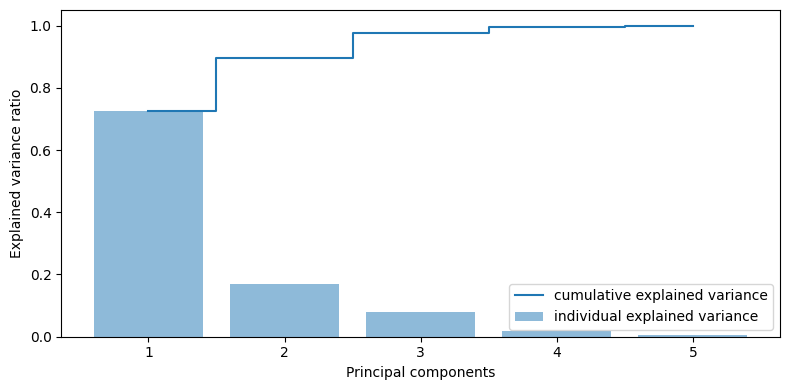

In [29]:
# PCA graph on crab data
plot_explained_variance(crabData)

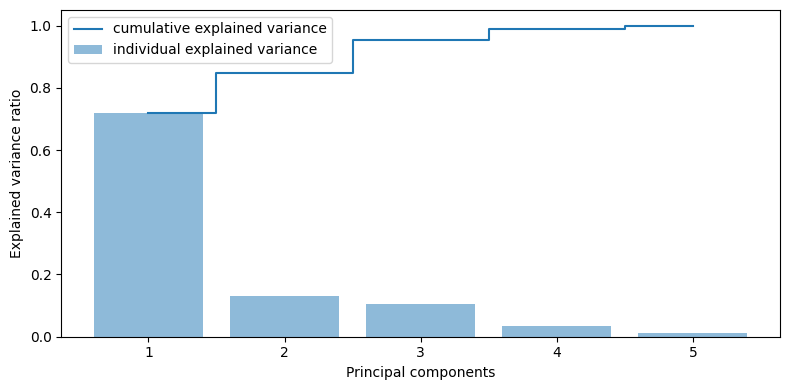

In [30]:
# PCA graph on sports car data
plot_explained_variance(sportsCarData)

## Independent Component Analysis (ICA)

In [31]:
import pandas as pd
from sklearn.decomposition import FastICA

def perform_ica(data, n_components=None):
    """
    Perform ICA on a dataset and return the transformed dataset with the
    specified number of independent components.

    :param data: A pandas DataFrame with only numeric z-scaled data.
    :param n_components: The number of independent components to keep.
    :return: A pandas DataFrame of the transformed dataset.
    """
    # Initialize ICA with the number of components to keep
    ica = FastICA(n_components=n_components, random_state=0)

    # Fit and transform the data
    independent_components = ica.fit_transform(data)

    # Create a DataFrame with the independent components
    ic_df = pd.DataFrame(data=independent_components,
                         columns=[f'IC{i+1}' for i in range(independent_components.shape[1])])

    return ic_df

# Example usage:
# Assume you have a pandas DataFrame `numericData` with z-scaled data
# Specify the number of components you want, for example, 5
#transformed_data = perform_ica(numericData, n_components=5)
#print(transformed_data)


In [32]:
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

def plot_ica_kurtosis(data, n_components=None, title='Kurtosis of Independent Components'):
    # Perform ICA
    ica = FastICA(n_components=n_components, random_state=0)
    components = ica.fit_transform(data)

    # Calculate kurtosis for each component
    kurtosis_values = kurtosis(components, axis=0, fisher=True) # Fisher's definition is used for comparison with normal distribution kurtosis

    # Plot the kurtosis values
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, len(kurtosis_values) + 1), kurtosis_values)
    plt.xlabel('Independent Components')
    plt.ylabel('Kurtosis')
    plt.title(title)
    plt.show()

    return kurtosis_values

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


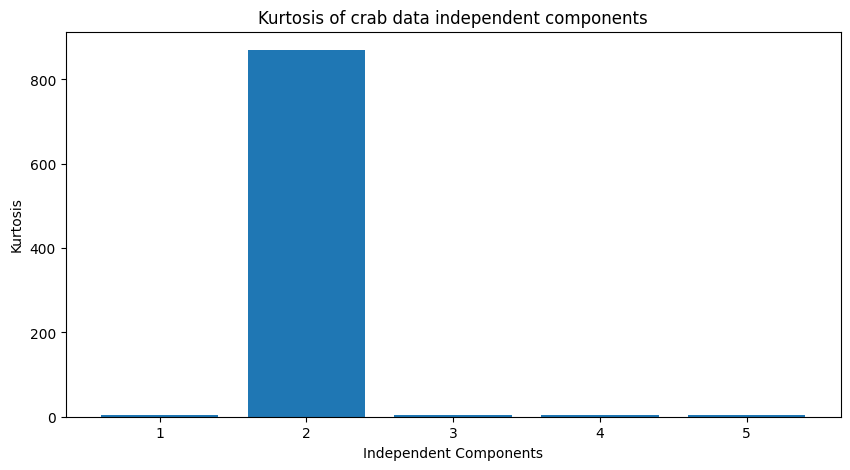

Selected components (0-indexed): [0 1 2 3 4]


In [33]:
# ICA graph crab data
# numericData is a pandas DataFrame with numeric values
ica_kurtosis_values = plot_ica_kurtosis(crabData, n_components=crabData.shape[1], title='Kurtosis of crab data independent components')

# Choose the number of components based on kurtosis
# For example, we might set a threshold and pick components that exceed this threshold
kurtosis_threshold = 1.0 # This is arbitrary and could be set based on domain knowledge or other criteria
selected_components = np.where(np.abs(ica_kurtosis_values) > kurtosis_threshold)[0]

print(f"Selected components (0-indexed): {selected_components}")

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


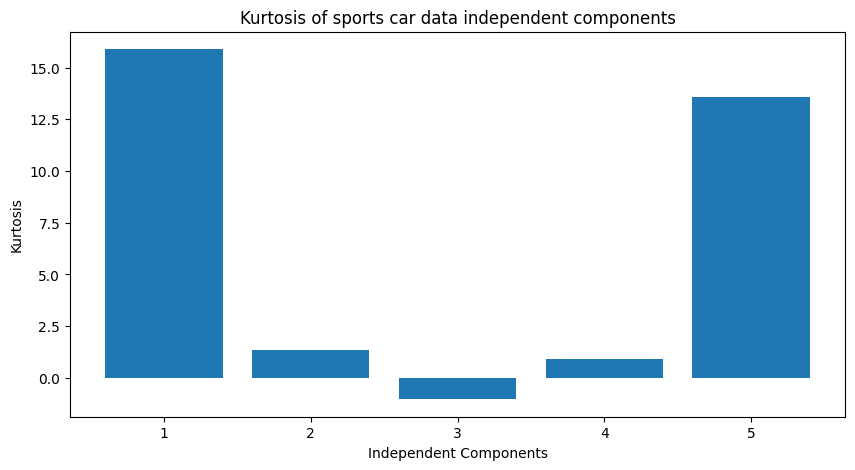

Selected components (0-indexed): [0 1 2 4]


In [34]:
# ICA graph sports car data
# numericData is a pandas DataFrame with numeric values
ica_kurtosis_values = plot_ica_kurtosis(sportsCarData, n_components=sportsCarData.shape[1], title='Kurtosis of sports car data independent components')

# Choose the number of components based on kurtosis
# For example, we might set a threshold and pick components that exceed this threshold
kurtosis_threshold = 1.0 # This is arbitrary and could be set based on domain knowledge or other criteria
selected_components = np.where(np.abs(ica_kurtosis_values) > kurtosis_threshold)[0]

print(f"Selected components (0-indexed): {selected_components}")

## Random Projection (RP)

In [35]:
import pandas as pd
from sklearn.random_projection import GaussianRandomProjection

def perform_random_projection(data, n_components='auto', eps=0.1):
    """
    Perform Random Projections on a dataset and return the transformed dataset
    with the specified number of dimensions.

    :param data: A pandas DataFrame with only numeric data.
    :param n_components: The number of dimensions to project down to.
                         If 'auto', the dimensionality is automatically chosen
                         based on eps according to the Johnson-Lindenstrauss lemma.
    :param eps: Parameter for choosing n_components automatically. Smaller values
                yield more conservative (larger) choices of n_components.
    :return: A pandas DataFrame of the transformed dataset.
    """
    # Initialize Random Projection with the number of components to keep
    rp = GaussianRandomProjection(n_components=n_components, eps=eps, random_state=0)

    # Fit and transform the data
    random_projections = rp.fit_transform(data)

    # Create a DataFrame with the random projections
    rp_df = pd.DataFrame(data=random_projections,
                         columns=[f'RP{i+1}' for i in range(random_projections.shape[1])])

    return rp_df

# Example usage:
# Assume you have a pandas DataFrame `numericData` with numeric data
# Specify the number of components you want, for example, 5 or 'auto'
#transformed_data = perform_random_projection(numericData, n_components=5)
#print(transformed_data)


In [36]:
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import mean_squared_error

def plot_reconstruction_errors(data, max_n_components, title='Reconstruction Error vs. Number of Components'):
    n_components_list = []
    errors = []

    for n_components in range(1, max_n_components + 1):
        # Perform Random Projection
        transformer = GaussianRandomProjection(n_components=n_components, random_state=0)
        X_projected = transformer.fit_transform(data)

        # Attempt to reconstruct the original data
        pseudo_inverse = np.linalg.pinv(transformer.components_.T)
        X_reconstructed = np.dot(X_projected, pseudo_inverse)

        # Compute the reconstruction error
        error = mean_squared_error(data, X_reconstructed)

        # Append the number of components and corresponding error to lists
        n_components_list.append(n_components)
        errors.append(error)

    # Plotting the graph
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_list, errors, marker='o')
    plt.title(title)
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.grid(True)
    plt.show()

# Call the function with your data and desired max number of components
# plot_reconstruction_errors(your_data, max_n_components=your_max_components)


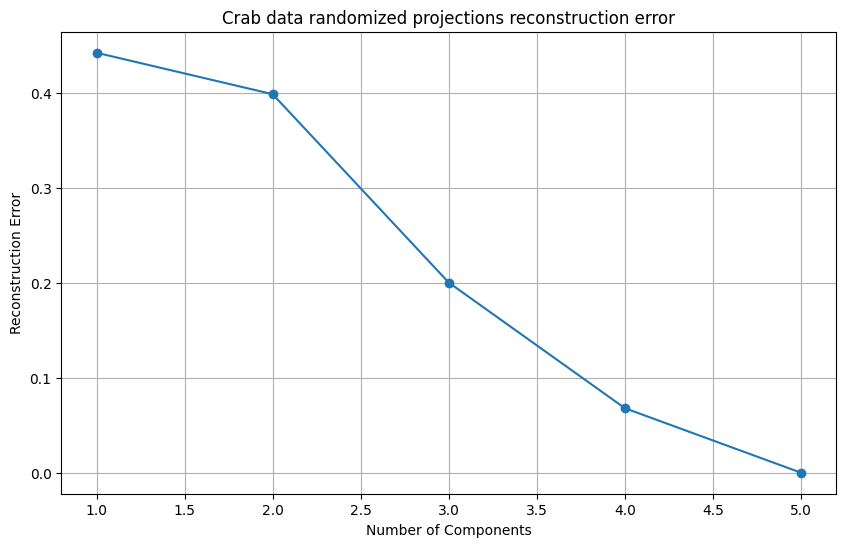

In [37]:
# Crab RP reconstruction error
plot_reconstruction_errors(crabData, 5, title='Crab data randomized projections reconstruction error')

#Acceptable trade off of dimensions to reconstruction error at 3 components

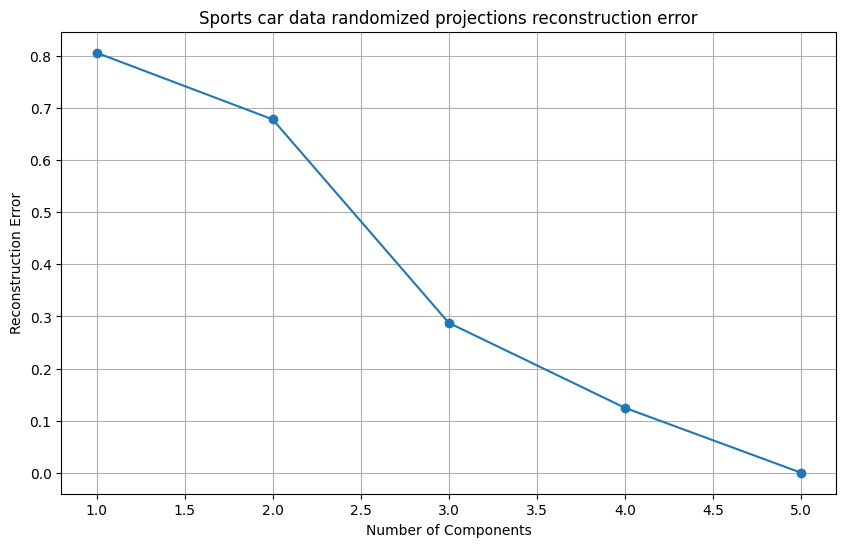

In [38]:
# Sports car RP reconstruction error
plot_reconstruction_errors(sportsCarData, 5, title='Sports car data randomized projections reconstruction error')

#Sharp drop to low reconstruction error at 3 components

## Manifold learning algorithm - t-distributed stochastic neighbor embedding

In [39]:
from sklearn.manifold import TSNE
import pandas as pd

def perform_tsne(data, n_components=2, perplexity=30.0, n_iter=1000, random_state=None):
    """
    Perform t-SNE on a dataset and return the transformed dataset with the
    specified number of components.

    :param data: A pandas DataFrame with only numeric z-scaled data.
    :param n_components: The number of components to keep.
    :param perplexity: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms.
    :param n_iter: Maximum number of iterations for the optimization.
    :param random_state: The seed of the pseudo random number generator.
    :return: A pandas DataFrame of the transformed dataset.
    """
    # Initialize t-SNE with the given parameters
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=random_state)

    # Fit and transform the data
    tsne_results = tsne.fit_transform(data)

    # Create a DataFrame with the t-SNE components
    tsne_df = pd.DataFrame(data=tsne_results,
                           columns=[f'tSNE{i+1}' for i in range(n_components)])

    return tsne_df

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def search_tsne_hyperparameters(data, perplexities=[5, 30, 50, 100], learning_rates=[10, 100, 1000], n_iter=1000, random_state=None):
    results = []
    for perplexity in perplexities:
        for learning_rate in learning_rates:
            try:
                # Initialize t-SNE with the current set of hyperparameters
                tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate,
                            n_iter=n_iter, random_state=random_state, n_iter_without_progress=n_iter//10)

                # Fit the model. Note: fit_transform is used here but we do not use the output.
                # We are interested in the kl_divergence_ attribute after fitting.
                tsne.fit(data)

                # Check if the kl_divergence_ is negative, which should not happen
                if tsne.kl_divergence_ < 0:
                    print(f"Warning: Negative KL divergence detected for perplexity {perplexity} and learning rate {learning_rate}")

                # Store the results
                results.append({
                    'perplexity': perplexity,
                    'learning_rate': learning_rate,
                    'kl_divergence': tsne.kl_divergence_
                })
            except Exception as e:
                print(f"An error occurred: {e}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plotting the results
    for perplexity in perplexities:
        subset = results_df[results_df['perplexity'] == perplexity]
        plt.plot(subset['learning_rate'], subset['kl_divergence'], label=f'Perplexity {perplexity}')

    plt.xlabel('Learning Rate')
    plt.ylabel('KL Divergence')
    plt.title('t-SNE Hyperparameter Search Results')
    plt.legend()
    plt.xscale('log')  # Learning rates can vary on a large scale so log scale is often more informative
    plt.show()

    return results_df


In [41]:
# Crab tSNE hyperparameter search
search_tsne_hyperparameters(crabData, random_state=42)
# Best hyper params are perplexity 100 with learning rate 100

KeyboardInterrupt: ignored

In [ ]:
# Sports Car data tSNE hyperparameter search
search_tsne_hyperparameters(sportsCarData, random_state=42)

In [ ]:
# Crab tSNE
perform_tsne(crabData, random_state=42)

In [ ]:
# Sports car tSNE
perform_tsne(sportsCarData, random_state=42)

## Expectation maximization clustering with dimensionality reduction

### EM PCA crab data

In [ ]:
PCA_crabData = perform_pca(crabData, n_components=1)
results = find_best_gmm(PCA_crabData, min_clusters=1, max_clusters=20)
graph_results(results, title='EM PCA crab data with 1 principle component')

### EM PCA sports car data

In [ ]:
PCA_sportsCarData = perform_pca(sportsCarData, n_components=1)
results = find_best_gmm(PCA_sportsCarData, min_clusters=1, max_clusters=50)
graph_results(results, title='EM PCA sports car data with 1 principle component')

### EM ICA crab data

In [ ]:
ICA_crabData = perform_ica(crabData, n_components=2)
results = find_best_gmm(ICA_crabData, min_clusters=1, max_clusters=20)
graph_results(results, title='EM ICA crab data with 2 independent component')

### EM ICA Sports Car data

In [ ]:
ICA_sportsCarData = perform_ica(sportsCarData, n_components=1)
results = find_best_gmm(ICA_sportsCarData, min_clusters=1, max_clusters=20)
graph_results(results, title='EM ICA sports car data with 1 independent component')

### EM RP Crab data

In [ ]:
data = crabData
reducedData = perform_random_projection(data, n_components=3)
results = find_best_gmm(reducedData, min_clusters=1, max_clusters=20)
graph_results(results, title='EM RP crab data with 3 random projections')

### EM RP Sports Car data

In [ ]:
data = sportsCarData
reducedData = perform_random_projection(data, n_components=3)
results = find_best_gmm(reducedData, min_clusters=1, max_clusters=20)
graph_results(results, title='EM RP sports car data with 3 random projections')

### EM tSNE Crab data

### EM tSNE Sports Car data

### Kmeans PCA Crab data

In [ ]:
data = crabData
reducedData = perform_pca(data, n_components=1)
results = find_best_kmeans(reducedData, min_clusters=1, max_clusters=10)
graph_results(results, title='Kmeans PCA crab data with 1 principle component')

### Kmeans PCA Sports Car data

In [ ]:
data = sportsCarData
reducedData = perform_pca(data, n_components=1)
results = find_best_kmeans(reducedData, min_clusters=1, max_clusters=10)
graph_results(results, title='Kmeans PCA sports car data with 1 principle component')

### Kmeans ICA Crab Data

In [ ]:
data = crabData
reducedData = perform_ica(data, n_components=2)
results = find_best_kmeans(reducedData, min_clusters=1, max_clusters=10)
graph_results(results, title='Kmeans ICA crab data with 2 independent components')

### Kmeans ICA Sports Car Data

In [ ]:
data = sportsCarData
reducedData = perform_ica(data, n_components=1)
results = find_best_kmeans(reducedData, min_clusters=1, max_clusters=10)
graph_results(results, title='Kmeans ICA sports car data with 2 independent components')

### Kmeans RP Crab data

In [ ]:
data = crabData
reducedData = perform_random_projection(data, n_components=3, eps=0.1)
results = find_best_kmeans(reducedData, min_clusters=1, max_clusters=10)
graph_results(results, title='Kmeans RP crab data with 3 components')

### Kmeans RP Sports Car data

In [ ]:
data = sportsCarData
reducedData = perform_random_projection(data, n_components=3, eps=0.1)
results = find_best_kmeans(reducedData, min_clusters=1, max_clusters=10)
graph_results(results, title='Kmeans RP sports car data with 3 components')

### Kmeans tSNE Crab data

In [ ]:
data = crabData
reducedData = perform_tsne(data, n_components=2, perplexity=100, n_iter=1000, random_state=None)
results = find_best_kmeans(reducedData, min_clusters=1, max_clusters=10)
graph_results(results, title='Kmeans tSNE sports car data with 2 components')

### Kmeans tSNE Sports Car data

In [ ]:
data = sportsCarData
reducedData = perform_tsne(data, n_components=2, perplexity=5, n_iter=1000, random_state=None)
results = find_best_kmeans(reducedData, min_clusters=1, max_clusters=10)
graph_results(results, title='Kmeans tSNE sports car data with 2 components')

## Crab data neural network with dimensionality reduction

In [88]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Initialize the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, alpha=0.001,
                    solver='adam', verbose=10, random_state=1,
                    learning_rate_init=.01)




### Neural network on unreduced crab data

In [89]:
crabDataWithLabel.head(5)

,Sex,Length,Diameter,Height,Weight,Age
0,0,0.056665,0.298727,0.280664,-0.326218,-0.626186
1,1,-2.242133,-2.368404,-1.846683,-1.826744,-1.607137
3,0,-1.040489,-1.161845,-1.447806,-1.196456,-0.299202
5,0,0.526873,0.235224,-0.384132,-0.012180,-0.953170
6,0,-0.518035,-0.590317,-0.650050,-0.866938,1.335716


In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split features and labels
X = crabDataWithLabel.iloc[:, 1:]  # Features (all columns except the first)
y = crabDataWithLabel.iloc[:, 0]   # Labels (the first column)

# If you need to stratify the split so that the proportions of the binary labels are the same
# in both training and testing datasets, you can use the 'stratify' parameter:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
ICA_X_train, ICA_X_test, ICA_y_train, ICA_y_test = train_test_split(perform_ica(X, 2), y, test_size=0.2, stratify=y, random_state=42)
tSNE_X_train, tSNE_X_test, tSNE_y_train, tSNE_y_test = train_test_split(perform_tsne(X, n_components=2, perplexity=100.0, n_iter=250, random_state=42), y, test_size=0.2, stratify=y, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [91]:
# Train the model
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Iteration 1, loss = 0.69279584
Iteration 2, loss = 0.68500404
Iteration 3, loss = 0.68132546
Iteration 4, loss = 0.68128879
Iteration 5, loss = 0.68008839
Iteration 6, loss = 0.67985274
Iteration 7, loss = 0.68016960
Iteration 8, loss = 0.67938279
Iteration 9, loss = 0.67985887
Iteration 10, loss = 0.67975665
Iteration 11, loss = 0.67778519
Iteration 12, loss = 0.67955438
Iteration 13, loss = 0.67753475
Iteration 14, loss = 0.68037496
Iteration 15, loss = 0.67920799
Iteration 16, loss = 0.67953384
Iteration 17, loss = 0.67683934
Iteration 18, loss = 0.67835120
Iteration 19, loss = 0.68260741
Iteration 20, loss = 0.68076832
Iteration 21, loss = 0.68286165
Iteration 22, loss = 0.68037370
Iteration 23, loss = 0.68118770
Iteration 24, loss = 0.67769008
Iteration 25, loss = 0.67699550
Iteration 26, loss = 0.68004726
Iteration 27, loss = 0.68224169
Iteration 28, loss = 0.67694405
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.54


In [92]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define a simple parameter grid
parameter_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (50,50,50), (50,50,50,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Initialize the classifier
mlpc = MLPClassifier(max_iter=1000)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=mlpc, param_grid=parameter_grid, n_jobs=-1, cv=3, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# The best hyperparameters from GridSearchCV
print('Best parameters found: ', grid_search.best_params_)

# You can also retrieve the best model directly
best_model = grid_search.best_estimator_

# And you can test it on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

KeyboardInterrupt: ignored

In [ ]:
# Train the model
mlp.fit(ICA_X_train, ICA_y_train)

# Make predictions
ICA_y_pred = mlp.predict(ICA_X_test)

# Calculate the accuracy
accuracy = accuracy_score(ICA_y_test, ICA_y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define a simple parameter grid
parameter_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (50,50,50), (50,50,50,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Initialize the classifier
mlpc = MLPClassifier(max_iter=1000)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=mlpc, param_grid=parameter_grid, n_jobs=-1, cv=3, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(ICA_X_train, y_train)

# The best hyperparameters from GridSearchCV
print('Best parameters found: ', grid_search.best_params_)

# You can also retrieve the best model directly
best_model = grid_search.best_estimator_

# And you can test it on the test set
y_pred = best_model.predict(ICA_X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Initialize the classifier
mlpc = MLPClassifier(max_iter=1000)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=mlpc, param_grid=parameter_grid, n_jobs=-1, cv=3, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(tSNE_X_train, tSNE_y_train)

# The best hyperparameters from GridSearchCV
print('Best parameters found: ', grid_search.best_params_)

# You can also retrieve the best model directly
best_model = grid_search.best_estimator_

# And you can test it on the test set
tSNE_y_pred = best_model.predict(tSNE_X_test)

# Calculate the accuracy
accuracy = accuracy_score(tSNE_y_test, tSNE_y_pred)
print(f"Accuracy: {accuracy:.2f}")

## Neural Network with clustering labels as features

### gmm cluster labels

In [94]:
def perform_em_clustering(data, n_clusters=3, random_state=None):
    """
    Performs clustering using Expectation Maximization (Gaussian Mixture Model) and returns cluster labels.

    :param data: A numpy array or pandas DataFrame with the data to cluster.
    :param n_clusters: The number of clusters to find.
    :param random_state: The seed of the pseudo random number generator to make the output deterministic.
    :return: A numpy array with cluster labels.
    """
    # Initialize the Gaussian Mixture model
    gmm = GaussianMixture(n_components=n_clusters, random_state=random_state)

    # Fit the model and predict cluster indices
    cluster_labels = gmm.fit_predict(data)

    return cluster_labels

In [104]:
gmm_clusters = perform_em_clustering(crabDataWithLabel.iloc[:, 1:], n_clusters = 3, random_state=42)

In [105]:
crabDataLabelEM = crabDataWithLabel.copy()
crabDataLabelEM['gmm_clusters'] = gmm_clusters

In [106]:
# Split features and labels
X_EM = crabDataLabelEM.iloc[:, 1:]  # Features (all columns except the first)
y_EM = crabDataLabelEM.iloc[:, 0]   # Labels (the first column)

EM_X_train, EM_X_test, EM_y_train, EM_y_test = train_test_split(X_EM, y_EM, test_size=0.2, stratify=y, random_state=42)

In [107]:
# Train the model
mlp.fit(EM_X_train, EM_y_train)

# Make predictions
EM_y_pred = mlp.predict(EM_X_test)

# Calculate the accuracy
accuracy = accuracy_score(EM_y_test, EM_y_pred)
print(f"Accuracy: {accuracy:.2f}")

Iteration 1, loss = 0.69086768
Iteration 2, loss = 0.68647229
Iteration 3, loss = 0.68447406
Iteration 4, loss = 0.68201861
Iteration 5, loss = 0.68229400
Iteration 6, loss = 0.68145968
Iteration 7, loss = 0.67958622
Iteration 8, loss = 0.67842325
Iteration 9, loss = 0.67780561
Iteration 10, loss = 0.67715519
Iteration 11, loss = 0.67780667
Iteration 12, loss = 0.67791828
Iteration 13, loss = 0.67769262
Iteration 14, loss = 0.67569979
Iteration 15, loss = 0.67751768
Iteration 16, loss = 0.67545498
Iteration 17, loss = 0.67496270
Iteration 18, loss = 0.67808281
Iteration 19, loss = 0.67500268
Iteration 20, loss = 0.67547826
Iteration 21, loss = 0.67409332
Iteration 22, loss = 0.67492178
Iteration 23, loss = 0.67376767
Iteration 24, loss = 0.67329202
Iteration 25, loss = 0.67334723
Iteration 26, loss = 0.67345435
Iteration 27, loss = 0.67308016
Iteration 28, loss = 0.67712610
Iteration 29, loss = 0.67383432
Iteration 30, loss = 0.67717404
Iteration 31, loss = 0.67415080
Iteration 32, los

### kmeans cluster labels

In [99]:
from sklearn.cluster import KMeans

def perform_kmeans_clustering(data, n_clusters=3, random_state=None):
    """
    Performs clustering using the K-means algorithm and returns cluster labels.

    :param data: A numpy array or pandas DataFrame with the data to cluster.
    :param n_clusters: The number of clusters to find.
    :param random_state: The seed of the pseudo random number generator to make the output deterministic.
    :return: A numpy array with cluster labels.
    """
    # Initialize the K-means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)

    # Fit the model and predict cluster indices
    cluster_labels = kmeans.fit_predict(data)

    return cluster_labels


In [100]:
kmeans_clusters = perform_kmeans_clustering(crabDataWithLabel.iloc[:, 1:], n_clusters = 2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [101]:
crabDataLabelKmeans = crabDataWithLabel.copy()
crabDataLabelKmeans['kmeans clusters'] = kmeans_clusters

In [102]:
# Split features and labels
X_Kmeans = crabDataLabelKmeans.iloc[:, 1:]  # Features (all columns except the first)
y_Kmeans = crabDataLabelKmeans.iloc[:, 0]   # Labels (the first column)

Kmeans_X_train, Kmeans_X_test, Kmeans_y_train, Kmeans_y_test = train_test_split(X_Kmeans, y_Kmeans, test_size=0.2, stratify=y, random_state=42)

In [103]:
# Train the model
mlp.fit(Kmeans_X_train, Kmeans_y_train)

# Make predictions
Kmeans_y_pred = mlp.predict(Kmeans_X_test)

# Calculate the accuracy
accuracy = accuracy_score(Kmeans_y_test, Kmeans_y_pred)
print(f"Accuracy: {accuracy:.2f}")

Iteration 1, loss = 0.69063201
Iteration 2, loss = 0.68788611
Iteration 3, loss = 0.68540271
Iteration 4, loss = 0.68366330
Iteration 5, loss = 0.68393959
Iteration 6, loss = 0.68280818
Iteration 7, loss = 0.68130311
Iteration 8, loss = 0.67995170
Iteration 9, loss = 0.67935172
Iteration 10, loss = 0.67830345
Iteration 11, loss = 0.67897915
Iteration 12, loss = 0.67971724
Iteration 13, loss = 0.67891079
Iteration 14, loss = 0.67745857
Iteration 15, loss = 0.67876546
Iteration 16, loss = 0.67690308
Iteration 17, loss = 0.67611316
Iteration 18, loss = 0.67906767
Iteration 19, loss = 0.67601249
Iteration 20, loss = 0.67677511
Iteration 21, loss = 0.67485078
Iteration 22, loss = 0.67532494
Iteration 23, loss = 0.67428933
Iteration 24, loss = 0.67376577
Iteration 25, loss = 0.67403265
Iteration 26, loss = 0.67421365
Iteration 27, loss = 0.67445320
Iteration 28, loss = 0.67784388
Iteration 29, loss = 0.67480946
Iteration 30, loss = 0.67634060
Iteration 31, loss = 0.67466998
Iteration 32, los